# contextual bandits

taylor solution towards context. can be viewed as markov process that randomly starts in some state and immediately terminates after an action is taken and reward is given.

There is a great video here explaining some awesome things:

https://www.youtube.com/watch?v=N5x48g2sp8M

The algorithms presented in the above linked video are on-line solutions.

Contextual bandits can also be tabular with hashed states or bins (imaging classifying customers into 5 bins then building 3 multi arm bandit value assesments for each bin).

Another means is offline where a value prediction is made by a multiple models trained at some interval towards success of each of the choices presented.

This also dives into concepts of learning and planning integration. Where we can blend on and off line learning.

Ulitmately it all comes down to this simplified procedural code algo:

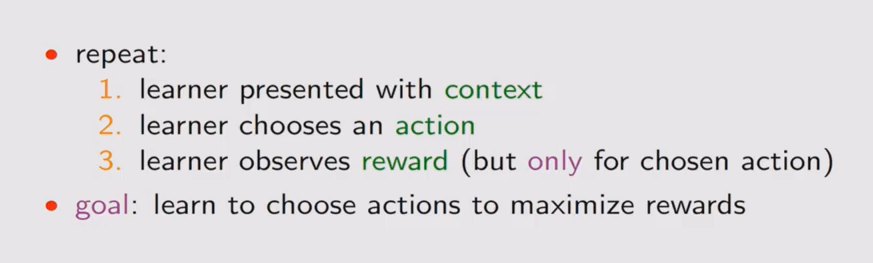

What we need to do here is set up some testing capabilities to try some various algorithms and ideas to acheive the goal of this algo....

## set up environment

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
from scipy.optimize import minimize

## user classes

In [2]:
class user_generator:
    def __init__(self):
        """
        beta is defined as
        [intercept, device, location, age]
        """
        self.beta = {}
        self.beta['a'] = np.array([-4, -0.1, -3, 0.1])
        self.beta['b'] = np.array([-6, -0.1, 1, 0.1])
        self.beta['c'] = np.array([2, 0.1, 1, -0.1])
        self.beta['d'] = np.array([4, 0.1, -3, -0.2])        
        self.beta['e'] = np.array([-0.1, 0, 0.5, -0.01])      
        self.context = None
        
    def logistic(self, beta, context):
        f = np.dot(beta, context)
        p = 1 / (1 + np.exp(-f))
        return p
    
    def display_ad(self, ad):
        if ad in ['a','b','c','d','e']:
            p = self.logistic(self.beta[ad], self.context)
            reward = np.random.binomial(n=1, p=p)
            return reward
        else:
            print("unknown ad!")
    
    def generate_user_with_context(self):
        # 0 = international, 1 = us
        location = np.random.binomial(n=1, p= 0.6)
        #0 =desktop, 1 = mobile
        device = np.random.binomial(n=1, p= 0.8)
        #age
        age = 10 + int(np.random.beta(2,3) * 60)
        # giving 1 for intercept
        self.context = [1,device,location,age]
        return self.context
        

#visualization function
def get_scatter(x, y, name, axis):
    
    axis.plot(x, y)
    axis.set_title(name)
    axis.set_xlabel('age')
    
    return axis

def visualize_bandits(user):
    plt.rcParams.update({'figure.figsize':[12, 8]}) 
    ad_list = 'abcde'
    ages = np.linspace(10,70)
    fig, axs = plt.subplots(2,2,  sharex=False, sharey=False)
    fig.tight_layout(pad=5.0)
    
    titles = [["desktop-international",
               "desktop-domestic"],
              ["mobile-international",
               "mobile-domestic"]]
    
    for device in [0,1]:
        for loc in [0,1]:
            name = titles[device][loc]
            for ad in ad_list:
                probs = [user.logistic(user.beta[ad], [1, device, loc, age]) for age in ages]
                axs[device][loc] = get_scatter(ages, probs, name, axs[device][loc])
    
    plt.legend(ad_list, loc='best', bbox_to_anchor=(0, 0, 0, 0))
    plt.show()
                
            
    

In [3]:
user = user_generator()

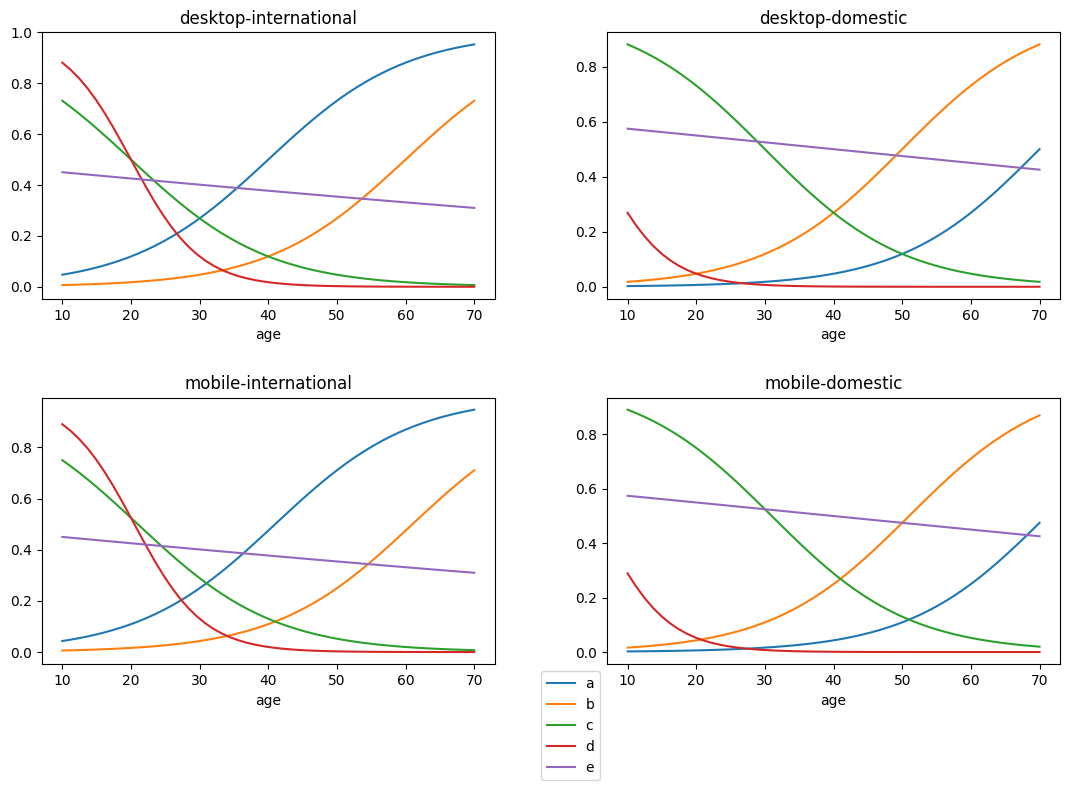

In [4]:
visualize_bandits(user)

These look sufficently messy

# Text Book Example
Function Approximation with Regularized Logisitc Regression

Model Click Thru Rate with Logistic

Batch Updating (semi-on-line)

Thompson Sampling

Thus Algo Provided bu Chappelle et al, 2011:

https://proceedings.neurips.cc/paper/2011/file/e53a0a2978c28872a4505bdb51db06dc-Paper.pdf

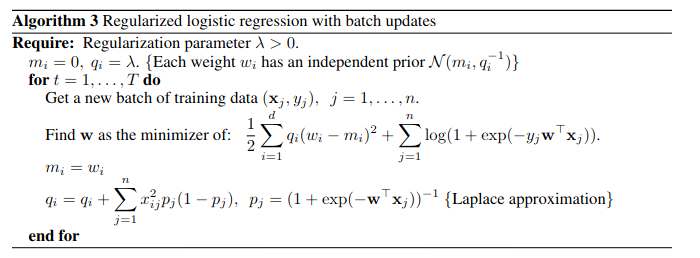

ultimately it is recommended to us an optimized variant of the code from skbayes:

https://github.com/AmazaspShumik/sklearn-bayes/tree/master/skbayes

We will also try other explore/exploit strategies :
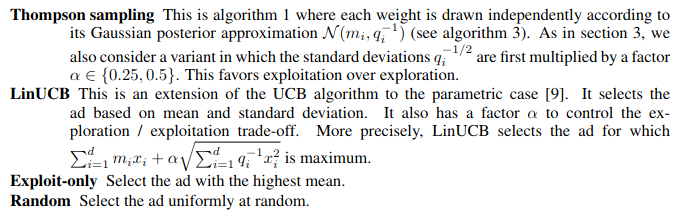

We will use epsilon greedy instead of pure exploit here as a modification, we can also use the same function for purely random choices.

some examples used tohelp understand how to code this problem

https://gdmarmerola.github.io/ts-for-contextual-bandits/

In [5]:
class reg_log_reg_batch:
    """
    Regularized logistic regression with batch updates
    
    from 
    https://proceedings.neurips.cc/paper/2011/file/e53a0a2978c28872a4505bdb51db06dc-Paper.pdf
    """
        # initializing
    def __init__(self, lambda_, alpha, n_dim):
        
        # the only hyperparameter is the deviation on the prior (L2 regularizer)
        self.lambda_ = lambda_
        self.alpha = alpha
                
        # initializing parameters of the model
        self.n_dim = n_dim, 
        self.m = np.zeros(self.n_dim) # mean value param estimate
        self.q = np.ones(self.n_dim) * self.lambda_
        
        # initializing weights
        self.w = self.get_weights()
                
    ####################################################################################################
    #Function Approximation with Regularized Logisitc Regression Using Thompson Sampling
    ####################################################################################################
    # method for sampling weights
    def get_weights(self):
        return np.random.normal(self.m, self.alpha * (self.q)**(-1/2))  
    
    
    #method to define the loss function
    def loss(self, w, *args):
        x, y = args
        n = len(y)
        regularizer = 0.5 + np.dot(self.q, (w - self.m)**2)
        predicted_loss = np.sum([np.log(1 + np.exp(-y[j] * w.dot(x[j]))) for j in range(y.shape[0])])                                             
        loss_val = regularizer + predicted_loss
        return loss_val
    
    #method to fit
    def fit(self, x, y):
        if y:
            x = np.array(x)
            y = np.array(y)
            #step 1 find w
            minimization = minimize(self.loss,
                                    self.w,
                                    args = (x, y),
                                    method = "L-BFGS-B",
                                    bounds = [(-10, 10)] * 3 + [(-1,1)],
                                    options = {'maxtier': 50})
            
            self.w = minimization.x
            self.m = self.w
            
            #step 2 update q w/ laplace approximation
            p = (1 + np.exp(np.matmul(self.w, -x.T)))**(-1)
            self.q += np.matmul(p*(1-p), (x**2))
            
    # sigmoid to get value assesment based on weights
    def calc_sigmoid(self, w, context):
        return 1/ (1 + np.exp(-np.dot(w, context)))
    
    # method to get prediction on what arm topull using log reg method
    def sample_prediction(self, context):
        #sampled params used with thompson sampling
        w = self.get_weights()
        return self.calc_sigmoid(w, context) 
    
    def get_prediction(self, context):
        #m is mean values param estimate
        return self.calc_sigmoid(self.m, context)     
    
    ####################################################################################################
    #Lin UCB 
    ####################################################################################################    
    #define ucb as an explore strategy
    def get_ucb(self, context):
        pred = self.calc_sigmoid(self.m, context)
        confidence = self.alpha * np.sqrt(np.sum(np.divide(np.array(context) ** 2, self.q)))
        ucb = pred + confidence
        
        #utilize with np.argmax(ucb) to determine action
        return ucb


    
 

# Regret Calculation



In [6]:
def calculate_regret(user, context, ad_options, ad):
    #ad is the ad shown to the user
    #because we have access to true probs we can use this as an oracle to calculate true regret
    action_values = {a: user.logistic(user.beta[a], context) for a in ad_options}
    best_action = max(action_values, key = action_values.get)
    regret = action_values[best_action] - action_values[ad]
    return regret, best_action


# code to leverage functions and solve 

In [7]:
stratgies = ['eps_greedy', 'random', 'linucb','thompson']
#stratgies = ['thompson']
results = []

for strategy in stratgies:
    print("testing :", strategy)
    
    alpha = 0.5
    lambda_ = 0.5
    n_dim = 4
    update_steps = 20
    ad_models = {ad: reg_log_reg_batch(alpha, lambda_, n_dim) for ad in 'abcde'}
    
    x = {ad: [] for ad in  'abcde'}
    y = {ad: [] for ad in  'abcde'} 
    
    total_regret = 0
    
    for i in range (10000):
        #generate a user
        context = user.generate_user_with_context()
        
        #select action based on strategy        
        if strategy == 'eps_greedy' or strategy == 'random':
            epsilon = 0.9
            if strategy == 'random':
                epsilon = 0
            
            if np.random.rand() <= epsilon:
                values = [ad_models[j].get_prediction(context) for j in 'abcde']
                
            else:
                values = [np.random.rand() for x in 'abcde']
               
                
        elif strategy == 'linucb':
            values = [ad_models[j].get_ucb(context) for j in 'abcde']
        
        elif strategy == 'thompson':
            values = [ad_models[j].sample_prediction(context) for j in 'abcde']
        
        #print(context)
        #print(values)
        action_max = np.max(values)
        #print(action_max)
        actions_to_pick = []
        for idx in range(len(values)):
            if values[idx] == action_max:
                actions_to_pick.append(idx)
        #print(actions_to_pick)
        action_idx = np.random.choice(actions_to_pick)
        #print(action_idx)
        action = 'abcde'[action_idx]       
        #print(action)
        
        #process action and observe reward
        reward = user.display_ad(action)
        
        #clock results
        x[action].append(context)
        y[action].append(reward)
        
        #clock regret
        regret, best_action = calculate_regret(user, context, 'abcde', action)
        total_regret += regret
        
        #clock telemetry
        results.append((strategy, i, context, action, reward, best_action, regret, total_regret))
        
        #update model(s)
        if (i + 1) % update_steps == 0:
            print("updating model at step ", i + 1)
            
            for ad in 'abcde':
                ad_models[ad].fit(x[ad],y[ad])
            
            slice_val = update_steps//2
            
            x = {ad: x[ad][slice_val:] for ad in  'abcde'}
            y = {ad: y[ad][slice_val:] for ad in  'abcde'} 
            
            if update_steps < 500:
                update_steps += update_steps
            else:
                update_steps = 500

results_df = pd.DataFrame(data = results, 
                          columns = [['strategy','step','context', 'action', 'reward', 'best_action', 'regret', 'total_regret']])


testing : eps_greedy
updating model at step  20
updating model at step  40
updating model at step  80
updating model at step  160
updating model at step  320
updating model at step  640


<ipython-input-5-f6321810f7e6>:46: OptimizeWarning: Unknown solver options: maxtier
  minimization = minimize(self.loss,


updating model at step  1000
updating model at step  1500
updating model at step  2000
updating model at step  2500
updating model at step  3000
updating model at step  3500
updating model at step  4000
updating model at step  4500
updating model at step  5000
updating model at step  5500
updating model at step  6000
updating model at step  6500
updating model at step  7000
updating model at step  7500
updating model at step  8000
updating model at step  8500
updating model at step  9000
updating model at step  9500
updating model at step  10000
testing : random
updating model at step  20
updating model at step  40
updating model at step  80
updating model at step  160
updating model at step  320
updating model at step  640
updating model at step  1000
updating model at step  1500
updating model at step  2000
updating model at step  2500
updating model at step  3000
updating model at step  3500
updating model at step  4000
updating model at step  4500
updating model at step  5000
updat

In [8]:
results_df

,strategy,step,context,action,reward,best_action,regret,total_regret
0,eps_greedy,0,"[1, 1, 0, 33]",c,0,e,0.162651,0.162651
1,eps_greedy,1,"[1, 1, 0, 20]",a,1,c,0.415882,0.578533
2,eps_greedy,2,"[1, 0, 0, 30]",a,0,e,0.132371,0.710904
3,eps_greedy,3,"[1, 0, 1, 47]",b,1,e,0.056950,0.767854
4,eps_greedy,4,"[1, 0, 0, 22]",c,1,c,0.000000,0.767854
...,...,...,...,...,...,...,...,...
39995,thompson,9995,"[1, 1, 0, 17]",e,1,d,0.235281,1036.124227
39996,thompson,9996,"[1, 0, 1, 26]",e,0,c,0.063745,1036.187972
39997,thompson,9997,"[1, 1, 1, 35]",e,1,e,0.000000,1036.187972
39998,thompson,9998,"[1, 1, 1, 25]",e,1,c,0.108226,1036.296199


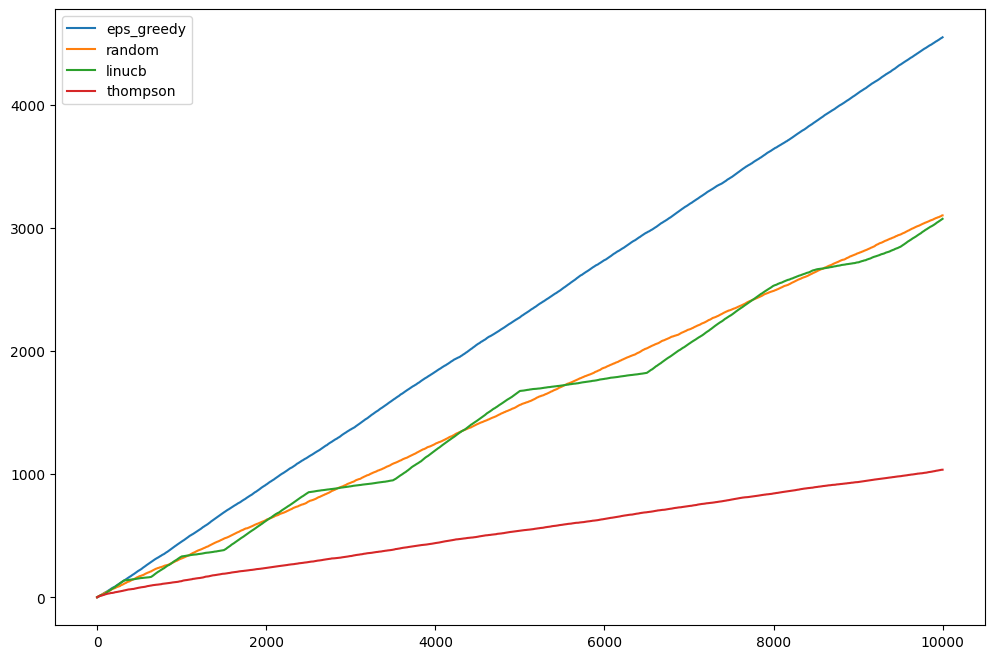

In [9]:
#review cumulative regret
import matplotlib.pyplot as plt
strategies = ['eps_greedy', 'random', 'linucb','thompson']

for i in range(len(strategies)):
    w = i * 10000
    x = results_df[w:w+9999]['step']
    y = results_df[w:w+9999]['total_regret']   
    plt.plot(x, y)

plt.legend(strategies, loc='best')    

plt.show()

In [10]:
results_df[:10000]

,strategy,step,context,action,reward,best_action,regret,total_regret
0,eps_greedy,0,"[1, 1, 0, 33]",c,0,e,0.162651,0.162651
1,eps_greedy,1,"[1, 1, 0, 20]",a,1,c,0.415882,0.578533
2,eps_greedy,2,"[1, 0, 0, 30]",a,0,e,0.132371,0.710904
3,eps_greedy,3,"[1, 0, 1, 47]",b,1,e,0.056950,0.767854
4,eps_greedy,4,"[1, 0, 0, 22]",c,1,c,0.000000,0.767854
...,...,...,...,...,...,...,...,...
9995,eps_greedy,9995,"[1, 0, 1, 31]",d,0,e,0.516999,4548.121753
9996,eps_greedy,9996,"[1, 0, 1, 19]",e,0,c,0.197952,4548.319706
9997,eps_greedy,9997,"[1, 1, 0, 35]",d,0,e,0.337207,4548.656913
9998,eps_greedy,9998,"[1, 0, 1, 35]",d,0,e,0.510025,4549.166938


In [11]:
results_df[:10000]["action"].value_counts()

(action,)
d            9156
b             222
e             216
c             210
a             196
dtype: int64

In [12]:
results_df[10000:20000]

,strategy,step,context,action,reward,best_action,regret,total_regret
10000,random,0,"[1, 1, 1, 55]",e,1,b,0.136118,0.136118
10001,random,1,"[1, 1, 1, 17]",d,0,c,0.711061,0.847178
10002,random,2,"[1, 0, 1, 11]",a,0,c,0.867160,1.714338
10003,random,3,"[1, 1, 0, 16]",a,0,d,0.635091,2.349429
10004,random,4,"[1, 1, 1, 41]",b,0,e,0.228559,2.577988
...,...,...,...,...,...,...,...,...
19995,random,9995,"[1, 1, 0, 37]",e,0,a,0.016696,3101.988722
19996,random,9996,"[1, 1, 1, 30]",a,0,c,0.508677,3102.497399
19997,random,9997,"[1, 0, 1, 44]",e,0,e,0.000000,3102.497399
19998,random,9998,"[1, 1, 0, 22]",d,0,c,0.049463,3102.546862


In [13]:
results_df[10000:20000]["action"].value_counts()

(action,)
e            2047
a            2018
b            2003
c            1996
d            1936
dtype: int64

In [14]:
results_df[20000:30000]

,strategy,step,context,action,reward,best_action,regret,total_regret
20000,linucb,0,"[1, 1, 1, 21]",a,0,c,0.724366,0.724366
20001,linucb,1,"[1, 0, 1, 34]",d,0,e,0.511977,1.236343
20002,linucb,2,"[1, 0, 1, 30]",d,0,e,0.518286,1.754629
20003,linucb,3,"[1, 1, 1, 18]",e,0,c,0.231056,1.985685
20004,linucb,4,"[1, 0, 1, 48]",d,0,e,0.479827,2.465511
...,...,...,...,...,...,...,...,...
29995,linucb,9995,"[1, 1, 1, 48]",d,0,e,0.479807,3072.951908
29996,linucb,9996,"[1, 0, 1, 27]",d,0,c,0.562314,3073.514222
29997,linucb,9997,"[1, 1, 1, 31]",d,0,e,0.516425,3074.030647
29998,linucb,9998,"[1, 1, 1, 34]",d,0,e,0.511661,3074.542307


In [15]:
results_df[20000:30000]["action"].value_counts()

(action,)
d            5554
e            4431
b              10
a               3
c               2
dtype: int64

In [16]:
results_df[30000:]

,strategy,step,context,action,reward,best_action,regret,total_regret
30000,thompson,0,"[1, 1, 1, 47]",b,0,e,0.081195,0.081195
30001,thompson,1,"[1, 1, 1, 49]",c,0,e,0.335664,0.416859
30002,thompson,2,"[1, 1, 1, 21]",a,0,c,0.724366,1.141225
30003,thompson,3,"[1, 1, 0, 17]",b,0,d,0.656059,1.797284
30004,thompson,4,"[1, 1, 0, 29]",a,0,e,0.172242,1.969526
...,...,...,...,...,...,...,...,...
39995,thompson,9995,"[1, 1, 0, 17]",e,1,d,0.235281,1036.124227
39996,thompson,9996,"[1, 0, 1, 26]",e,0,c,0.063745,1036.187972
39997,thompson,9997,"[1, 1, 1, 35]",e,1,e,0.000000,1036.187972
39998,thompson,9998,"[1, 1, 1, 25]",e,1,c,0.108226,1036.296199


In [17]:
results_df[30000:]["action"].value_counts()

(action,)
e            9737
c             195
d              57
b               8
a               3
dtype: int64